In [1]:
# make modules in parent directory importable 
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

### Increasing mean read depth is expected to increase the signal-to-noise ratio

Read depth $N$ can be interpreted as a noisy signal: the signal is assumed to be a number $N_s$ that is dependent upon the local DNA sequence and the noise comes from Poisson fluctuations about that signal: 

\begin{equation} 
P(N=k) = \frac{N_s^{k} e^{-N_s}}{k!} .
\end{equation} 

The signal-to-noise ratio is therefore 

\begin{equation} 
\frac{\langle N \rangle}{\sigma(N)} = \frac{N_s}{\sqrt{N_s}} = \sqrt{N_s} = \sqrt{\langle N \rangle}, 
\end{equation} 

which grows as the mean depth increases: 


Text(0,0.5,'signal-to-noise ratio')

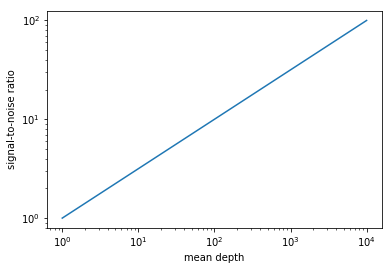

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt 
import numpy as np 

mean_depth = np.arange(1,10000)
SNR = np.sqrt(mean_depth)
plt.loglog(mean_depth, SNR)
plt.xlabel('mean depth')
plt.ylabel('signal-to-noise ratio')

When the signal to noise ratio is small, variation in $N_s$ will be un-noticeable because it will be drowned in the Poisson noise. Conversely, when the signal-to-noise ratio is large, variation in $N_s$ will be detectable above the noise. 

To illustrate, suppose

\begin{equation} 
N_s = \alpha ( 1 \pm \beta ) ,
\end{equation} 

where $\beta \ll 1$ is the fractional variation in the signal and $\alpha$ is the mean signal. 




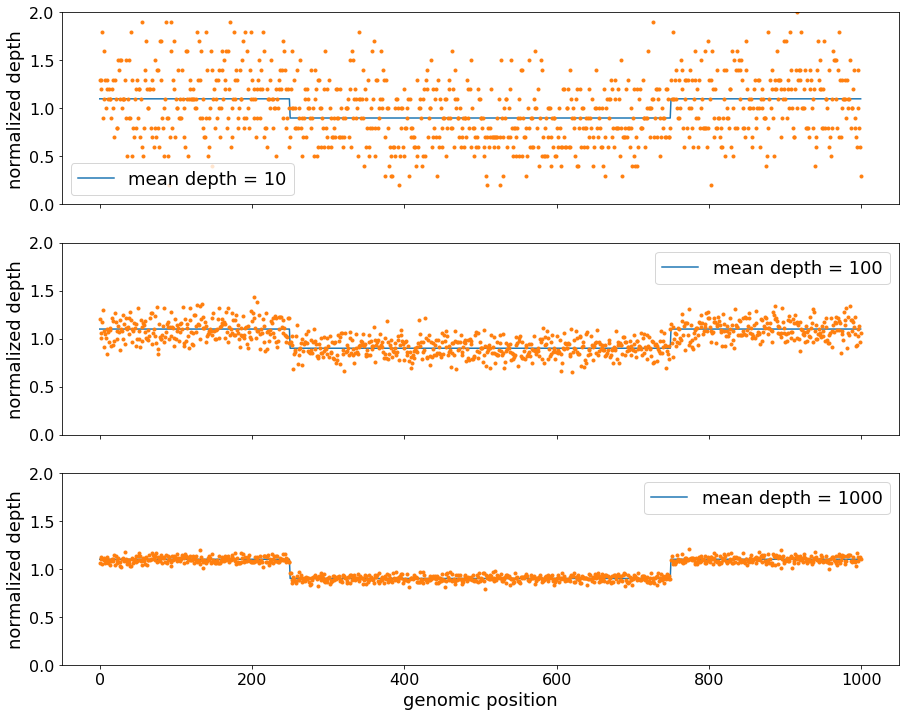

In [3]:
from plot import format_fig, format_axis

def compute_signals(positions, alpha=1, beta=0.1): 
    L1 = np.percentile(positions, 25)
    L2 = np.percentile(positions, 75)
    signals = np.ones_like(positions, dtype=float)*alpha*(1-beta)
    signals[(positions < L1) | (positions > L2)] = alpha*(1+beta)
    return signals

def compute_noisy_signals(signals):
    depths = np.random.poisson(lam = signals[:, np.newaxis], size=(len(signals), 1)) 
    return depths.flatten()

def plot_noisy_signal(axis, alpha): 
    positions = np.arange(1000)
    signals = compute_signals(positions, alpha)
    noisy_signals = compute_noisy_signals(signals)
    axis.plot(positions, signals/alpha, '-', label='mean depth = {}'.format(alpha))
    axis.plot(positions, noisy_signals/alpha, '.')
    axis.set_ylim([0, 2])
    axis.set_ylabel('normalized depth')
    axis.legend()
    format_axis(axis)
    
def plot_noisy_signals(figure_file_name=None): 
    alphas = [10, 100, 1000]
    figure, axes = plt.subplots(len(alphas), 1, sharex=True, sharey=True)
    format_fig(figure, height=12)
    for axis, alpha in zip(axes, alphas): 
        plot_noisy_signal(axis, alpha)
    axis.set_xlabel('genomic position')
    if figure_file_name:
        plt.savefig(figure_file_name, bbox_inches='tight')

plot_noisy_signals(figure_file_name='1.1B.1.pdf')

In line with expectations from our signal-to-noise ratio calculation, the true variation in the signal becomes apparent in the Poisson-contaminated signal as  the mean depth increases. 

### Systematic biases in real depth data emerge out of the noise when samples are pooled 

Armed with intution about what to expect when the mean-depth is increased, let us now turn to real data to see whether those expectations are borne out. We pooled the read depths across hundreds of samples to simulate the effect of increasing the mean sequencing depth. Let's examine that pooled read-depth profile across the entire length of chromosome 22 ... 

No handles with labels found to put in legend.
No handles with labels found to put in legend.


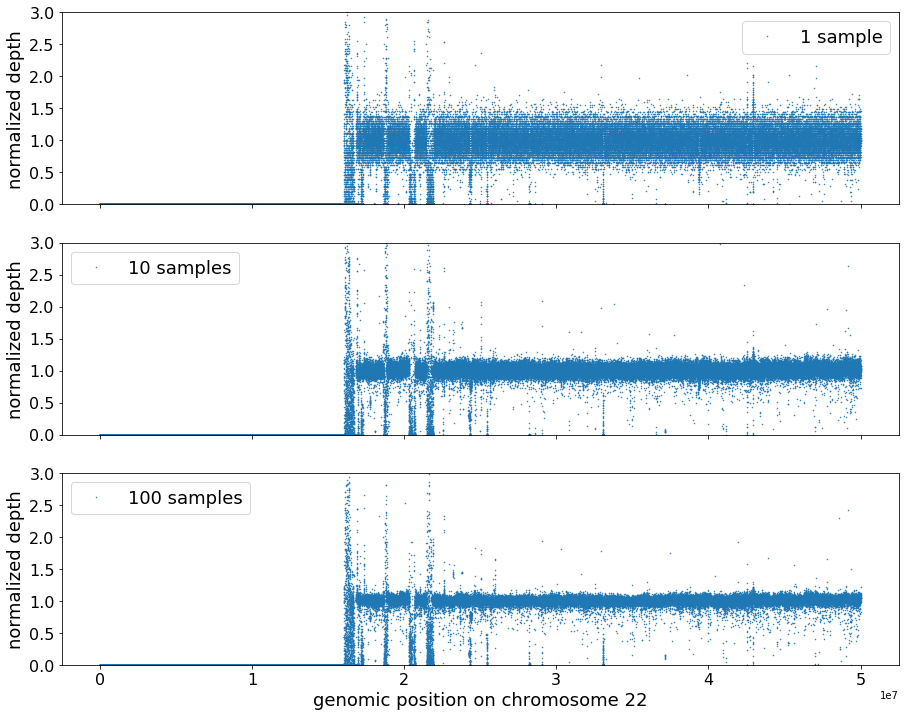

In [4]:
def plot_depth_profile(axis, data, region, normalized_depth_max, size, grid):
    assert('.'.join(data['file_name'].split('.')[1:]) == 'multicov.bin')
    import re
    chromosome, start, end = re.split(':|-', region)
    assert(int(chromosome) == 22)
    depths = np.fromfile('../../data/train_dev_data/' + data['file_name'], dtype=np.int32)
    mean_depth = np.mean(depths[int(25e6):int(50e6)])
    sampled_positions = np.random.choice(np.arange(int(start), int(end), dtype=int), size=size, replace=False)
    sampled_depths = depths[sampled_positions]
    axis.plot(sampled_positions, sampled_depths/mean_depth, '.', ms=1, label=data['title'])
    axis.set_ylabel('normalized depth')
    axis.set_ylim([0, normalized_depth_max])
    if grid:
        axis.grid(which='major', axis='y')
    plt.legend(loc=1)
    format_axis(axis)
    axis.yaxis.set_major_locator(plt.MultipleLocator(0.5))
    return 'genomic position on chromosome ' + chromosome

def plot_depth_profiles(region, normalized_depth_max=3, size=100000, grid=None, figure_file_name=None): 
    data_sets = [{'file_name': '1.multicov.bin', 'title': '1 sample'},
                 {'file_name': '10.multicov.bin', 'title': '10 samples'},
                 {'file_name': '100.multicov.bin', 'title': '100 samples'}]
    figure, axes = plt.subplots(3, 1, sharex=True, sharey=True)
    format_fig(figure, height=12)
    for axis, data_set in zip(axes, data_sets): 
        xlabel = plot_depth_profile(axis, data_set, region=region, normalized_depth_max=normalized_depth_max, size=size, grid=grid)
    axis.set_xlabel(xlabel)
    if figure_file_name:
        plt.savefig(figure_file_name, bbox_inches='tight')


plot_depth_profiles(region='22:0-50000000')

As expected theoretically, the noise in the normalized depth profile decreases as the mean depth (number of samples) increases. 

Zooming in, we notice, interestingly, that there are "events" within which the read depth seems to be approximately exponential (with smaller read depths more frequent than larger read depths). These inter-event distributions are clearly not Poisson noise. I wonder if there is an hypothesis for the origin of these inter-event fluctuations?


No handles with labels found to put in legend.
No handles with labels found to put in legend.


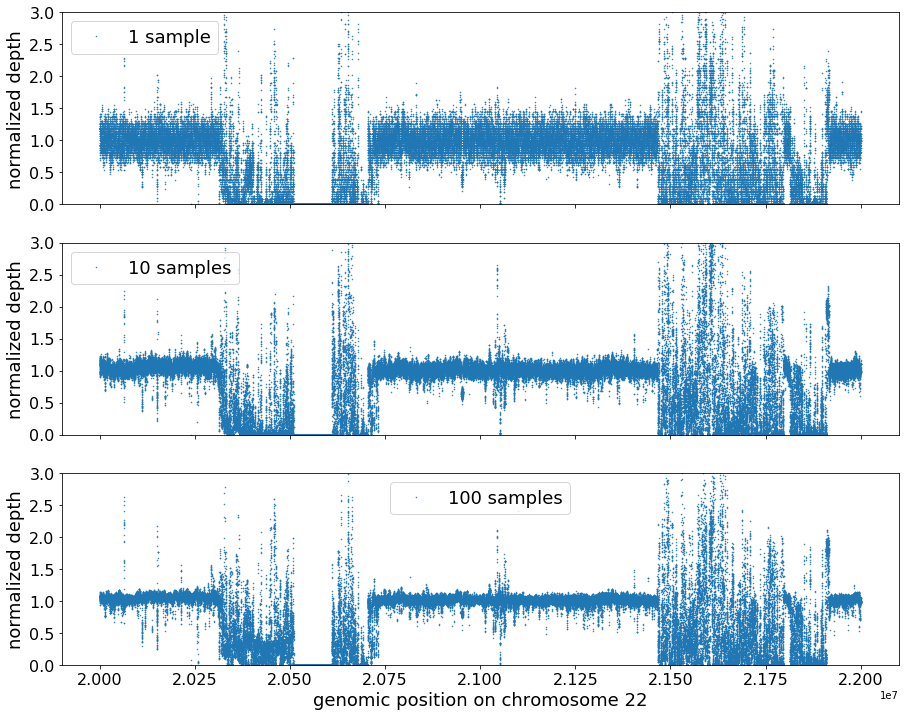

In [5]:
plot_depth_profiles(region='22:20000000-22000000')

Repeating this analysis in another region illustates nicely how pooling samples gives us the power to detect what appears to be variation in signal that would otherwise be invisible. As Poisson noise is dialed down in the following plots, real signals emerge, including what appear to be a number of copy-number variants (peaks and troughs that coincide with half-integer values of normalized depth) and smaller variations in coverage, presumably driven by variations in sequence...

No handles with labels found to put in legend.
No handles with labels found to put in legend.


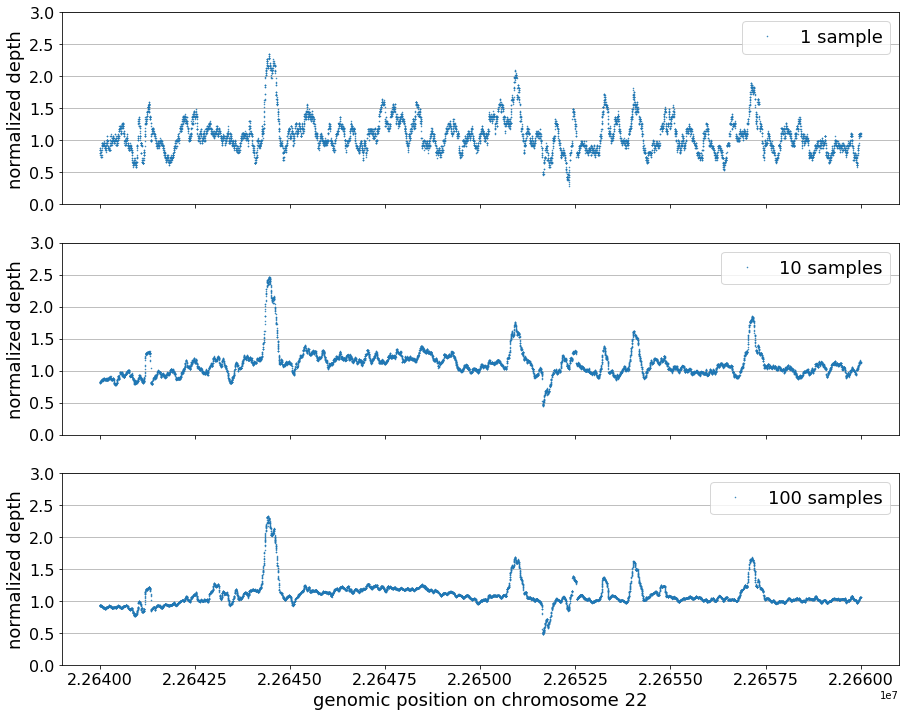

In [6]:
plot_depth_profiles(region='22:22640000-22660000', size=10000, grid=True, figure_file_name='1.1B.2.pdf')

### Hints that the model learns something useful when trained on pooled samples

Having corrected the rampant "mislabeling" of training examples resulting from Poisson noise, we trained the model again and examined its ability to filter out what appear to be systematic variations in read depth that don't result from CNVs...

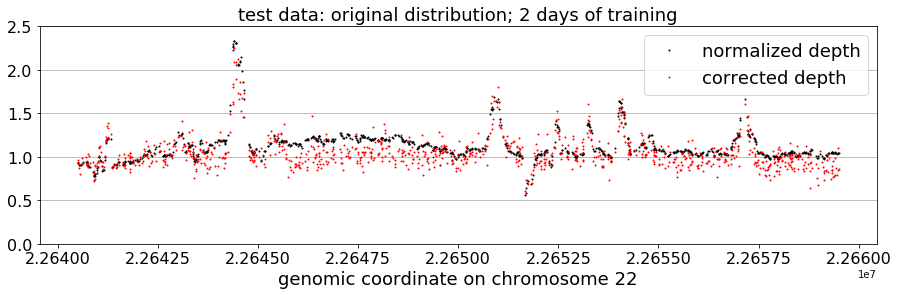

In [7]:
trained_models = [
    {'path': '../../data/trained_models/09_100samples_day2/09_100samples_originalDistribution/', 'annotation': 'original distribution; 2 days of training'},
]

from plot import plot_corrected_depths_test_all
plot_corrected_depths_test_all(trained_models, chromosome_number=22, max_y=2.5)

This seems to work quite nicely: the spikes that occur near half-integer values of normalized depth, and are therefore likely to be CNVs,  survive the denoising, while other fluctuations in read depth get shifted toward unit values of normalized read depth. Put another way, after this "early stopping", the algorithm seems to be able to use sequence to predict small fluctuations in read depth but not larger fluctuations... presumably because those are are independent of sequence...

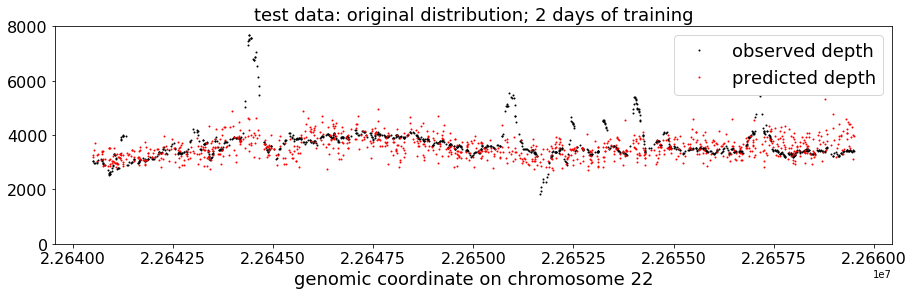

In [8]:
from plot import plot_depths_test_all
plot_depths_test_all(trained_models, chromosome_number=22, max_depth=8000)

Here are details of the early stopping...

observed_depth_mean 3284.842
feature_independent_cost 65.99666561647801


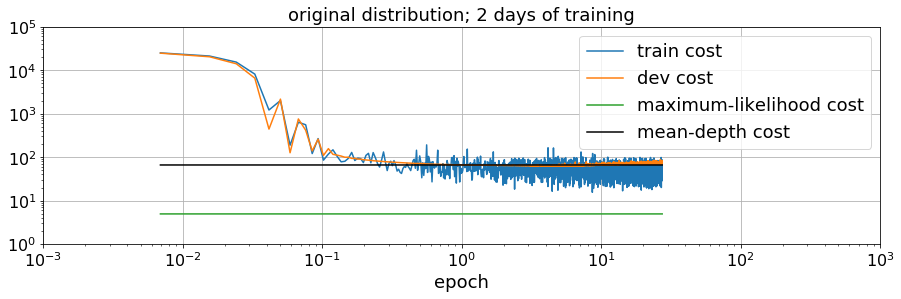

In [9]:
start_epoch = 0.001
end_epoch = 1000
min_cost = 1
max_cost = 100000

from plot import plot_costs_all
plot_costs_all(trained_models, start_epoch=start_epoch, end_epoch=end_epoch, min_cost=min_cost, max_cost=max_cost, loglog=True)

In [10]:
!./tensorboard.sh 09_100samples_day2/09_100samples_originalDistribution

/bin/sh: ./tensorboard.sh: No such file or directory
